In [135]:
with open('LLM.txt','r') as file:
    lines = file.readlines()
data = []
for line in lines:
    if len(line.strip().split(' ')) > 10:
        data.append(''.join(line.strip()))

print(len(data))

59


In [136]:
with open('stopwoorden.txt','r') as file:
    stopwoorden = file.read()

import string

def preprocess_sentence(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.translate(str.maketrans('', '', string.digits))
    text = text.lower().split()
    
    text = [token for token in text if token not in stopwoorden]
    return text


In [137]:
sentences = []
vocab = set()
for line in data:
    line_preprocessed = preprocess_sentence(line)
    sentences.append(line_preprocessed)
    for i in line_preprocessed:
        vocab.add(i)
print(sentences)
print(len(vocab))


[['kanker', 'medisch', 'latijn', 'neoplasma', 'malignum', 'kwaadaardig', 'nieuwgevormd', 'weefsel', 'ziekte'], ['cellen', 'onbeheerst', 'vermenigvuldigen'], ['woekerende', 'cellen', 'omliggend', 'weefsel', 'richten', 'schade', 'invasieve', 'groei', 'infiltratie'], ['woekerende', 'cellen', 'verspreiden', 'plaatsen', 'lichaam', 'metastasering', 'uitzaaiing', 'lymfevaten', 'lymfogene', 'metastasering', 'bloed', 'hematogene', 'metastasering', 'verschillende', 'lichaamsholten', 'bijvoorbeeld', 'buikholte'], ['nagenoeg', 'medische', 'specialismen', 'behandeling', 'kanker', 'medisch', 'specialisten', 'oncologie', 'radiotherapie', 'kanker', 'doodsoorzaak'], ['lezing', 'erasmus', 'kanker', 'universiteit'], ['kanker', 'klassiek', 'latijnse', 'cancer', 'vanuit', 'romeinse', 'encyclopedieschrijver', 'celsus'], ['kanker', 'aandoening', 'gekenmerkt', 'onbeheerste', 'groei', 'abnormaal', 'weefsel', 'neoplasie', 'aanhoudende', 'ongecontroleerde', 'celdeling', 'gezonde', 'cellen', 'lichaam', 'prolifere

In [138]:
import numpy as np
def create_pairs(sentences, w_size):
    X = []
    y = []

    for sentence in sentences:
        for i, w in enumerate(sentence):
            # Bepaal het venster
            start_idx = max(i - w_size, 0)
            end_idx = min(i + w_size + 1, len(sentence))

            # Contextwoorden (exclusief het target-woord zelf)
            context = sentence[start_idx:i] + sentence[i+1:end_idx]

            X.append(context)
            y.append(w)
    X = np.array(X, dtype=object)
    y = np.array(y, dtype=object)
    return X, y

In [139]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

X, y = create_pairs(sentences, 3)

def prepare_train_test_data(X, y, test_size=0.25, random_state=42):
    X_combined = [" ".join(context) for context in X]

    vectorizer_X = CountVectorizer(max_features=695)
    vectorizer_y = CountVectorizer()

    X_sparse = vectorizer_X.fit_transform(X_combined)
    y_sparse = vectorizer_y.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(
        X_sparse, y_sparse, test_size=test_size, random_state=random_state)
    
    return X_train, X_test, y_train, y_test


from sklearn.neural_network import MLPClassifier

def train_mlp_classifier(X_train, y_train, hidden_layer_sizes=(100,), random_state=42):
    model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, random_state=random_state, max_iter=500)
    
    y_train = np.asarray(y_train)
    
    model.fit(X_train, y_train)
    return model


In [140]:
X_train, X_test, y_train, y_test = prepare_train_test_data(X, y)

y_train_encoded = np.argmax(y_train, axis=1)
y_test_encoded = np.argmax(y_test, axis=1)

y_train_encoded = np.asarray(y_train_encoded)
y_test_encoded = np.asarray(y_test_encoded)

mlp_model = train_mlp_classifier(X_train, y_train_encoded)

train_accuracy = mlp_model.score(X_train, y_train_encoded)
test_accuracy = mlp_model.score(X_test, y_test_encoded)

print(f'TrainScore = {train_accuracy*100}%')
print(f'TestScore = {test_accuracy*100}%')


/homes/blkoobs/Documents/Jaar_3/Blok2/.llm/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TrainScore = 100.0%
TestScore = 4.081632653061225%


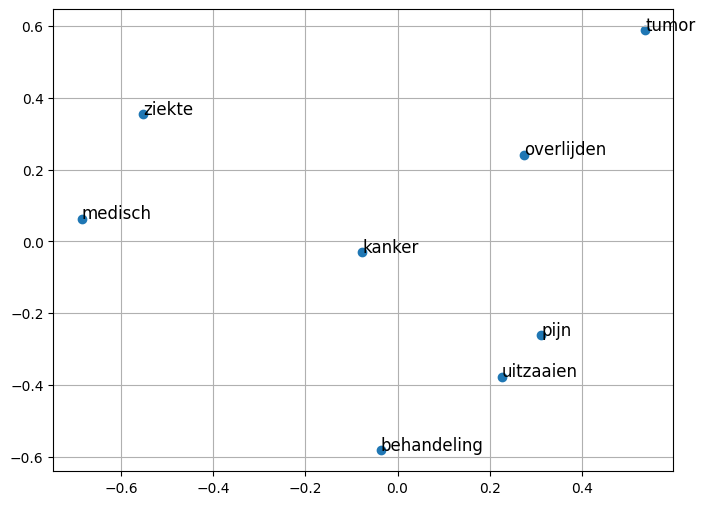

In [141]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

input_to_hidden_weights = mlp_model.coefs_[0]
word_vector = {}

for idx, word in enumerate(vocab):
    word_vector[word] = input_to_hidden_weights[idx]

for word in word_vector:
    word_vector[word] = word_vector[word] / np.linalg.norm(word_vector[word])

#print(word_vector['kanker'])


selected_words = ['kanker', 'tumor', 'ziekte', 'medisch', 'behandeling', 'pijn', 'uitzaaien', 'overlijden']
word_vectors = np.array([word_vector[word] for word in selected_words])

pca = PCA(n_components=2)
pca_result = pca.fit_transform(word_vectors)

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1])

for i, word in enumerate(selected_words):
    plt.text(pca_result[i, 0], pca_result[i, 1], word, fontsize=12)

plt.grid(True)
plt.show()
